In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image
import numpy as np
import cv2

In [22]:
def edge_kernels():
  """
  Kernel (matriz de transformacion) para la deteccion de bordes en imagenes
  de alta resolución
  """
  feldman = np.array([
      [10, 10, 20, 10, 10],
      [3, 3, 10, 3, 3],
      [0, 0, 0, 0, 0],
      [-3, -3, -10, -3, -3],
      [-10, -10, -20, -10, -10], ])
  return feldman

In [24]:
def convolve_images(img, kernel):
  """
  Proceso de convolución (multiplicacion de matrices) en la images con el kernel
  seleccionado
  """
  img_edge_x = signal.convolve2d(
      img, kernel, boundary='symm', mode='same')
  img_edge_y = signal.convolve2d(
      img, kernel.transpose(), boundary='symm', mode='same')
  img_edge = np.sqrt(img_edge_x**2+img_edge_y**2)
  return img_edge

In [26]:
def read_image(name, path=""):
  """
  Lectura de la imagen y aplicacion del filtro de alto contraste
  """
  img_original = cv2.imread(path+name, 1)
  img = high_contrast_image(img_original)[:, :, 0]
  img_original = Image.open(path+name).convert("RGB")
  return img_original, img

In [5]:
def high_contrast_image(img):
  """
  Funcion que aplica el alto contraste a la imagen cargada
  """
  # CLAHE (Contrast Limited Adaptive Histogram Equalization)
  clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8, 8))
  # convert from BGR to LAB color space
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)  # split on 3 different channels
  l2 = clahe.apply(l)  # apply CLAHE to the L-channel
  lab = cv2.merge((l2, a, b))  # merge channels
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
  return img

In [41]:
def plot_image(images, name="result.png", titles=["Original","Bordes"], path=""):
  """
  Función que grafica las dos imagenes en una sola, de lado izquierdo la original
  y de lado derecho con bordes
  """
  fig = plt.figure(figsize=(13,5))
  axs = [fig.add_subplot(1,2,i+1) for i in range(2)]
  axs = np.reshape(axs, 2)
  plt.subplots_adjust(left=0, bottom=0, right=1,
                      top=0.957, wspace=0, hspace=0)
  for ax, image, title in zip(axs, images, titles):
      individual_plots(ax, image, title)
  plt.savefig(path+name, bbox_inches="tight",pad_inches=0)


def individual_plots(ax, image, title=""):
  #Ploteo de cada imagen
  ax.axis("off")
  ax.set_title(title, fontsize=16)
  ax.imshow(image, cmap="gray")

In [7]:
"""
Instrucciones para leer datos de Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')
dir_drive="drive/MyDrive/"

Mounted at /content/drive


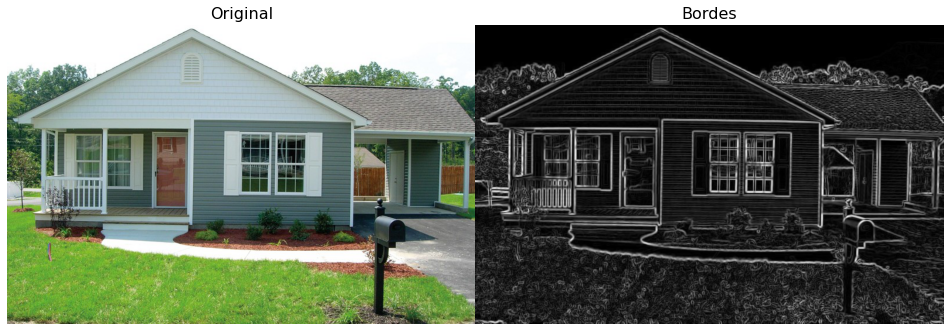

In [42]:
# Obtención del Kernel a usar
kernel = edge_kernels()
# Localizacion de la imagen (eliminar dir_drive cuando se ejecuta en local)
file = dir_drive+"image.jpg"
final_images = []
# Lectura de la imagen y obtención de la misma con el alto contraste
img_original, img = read_image(file)
final_images.append(img_original)
# Aplicación de la convolución a la imagen
img_edge = convolve_images(img, kernel)
final_images.append(img_edge)
# Ploteo de la imagen original y con detección de bordes
# (eliminar path=dir_drive) cuando se trabaja en local
plot_image(final_images,path=dir_drive)
